> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from personalization parameters (the decoder used in the co-adaptation algorithm). Thus, implement a basic ML model to link the decoder matrices back to the corresponding subject.  

- 14 Subjects, therefore random guessing would be 7.14% correct on average

In [99]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *
from experiment_params import *

import warnings
warnings.filterwarnings("ignore")

random.seed(a=1)

# Load In Data

I'm just making the flatten array input DF here

In [100]:
dec_flattened_df1 = pd.read_csv("Data\dec_full_flattened_df1.csv")
dec_flattened_df2 = pd.read_csv("Data\dec_full_flattened_df2.csv")

dec_norms_df1 = pd.read_csv("Data\decoder_full_norms1.csv")
dec_norms_df2 = pd.read_csv("Data\decoder_full_norms2.csv")

In [101]:
dec_norms_df = pd.concat((dec_norms_df1, dec_norms_df2))
dec_flattened_df = pd.concat((dec_flattened_df1, dec_flattened_df2))
if dec_flattened_df.columns[0]=='Unnamed: 0':
    dec_flattened_df.drop('Unnamed: 0', axis=1, inplace=True)

print(dec_flattened_df.shape)
dec_flattened_df.head()

(4256, 4)


,Subject,Condition,Update Number,Flattened Decoder
0,METACPHS_S106,0,0,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
1,METACPHS_S106,0,1,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
2,METACPHS_S106,0,2,[-0.34157085 0.08410593 -0.54057447 0.444319...
3,METACPHS_S106,0,3,[-0.17386248 0.00370517 0.40721562 -0.515221...
4,METACPHS_S106,0,4,[ 0.83210615 -1.32612423 0.28718983 1.302252...


In [102]:
print(dec_norms_df.shape)
dec_norms_df.drop('Unnamed: 0', axis=1, inplace=True)
dec_norms_df.head()

(4256, 5)


,Subject,Condition,Update Number,Frobenius Norm
0,METACPHS_S106,0,0,0.066360
1,METACPHS_S106,0,1,0.066360
2,METACPHS_S106,0,2,9.709390
3,METACPHS_S106,0,3,8.209080
4,METACPHS_S106,0,4,10.406943


# Classification
1. Logistic Regression
2. K-Nearest Neighbor
3. Gaussian Naive Bayes
4. Linear SVC
5. Stochastic Gradient Descent
6. Decision Tree Classifier
7. Gradient Boosting Trees

In [103]:
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

my_models = [LogisticRegression(), KNeighborsClassifier(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

## 1) Linking Matrix Norms to Participants

In [104]:
norm_label_df = dec_norms_df.drop(["Condition", "Update Number", "Frobenius Norm"], axis=1)
norm_label_df["Subject"] = norm_label_df["Subject"].map(key_to_num)
norm_label_df.head()

,Subject
0,0
1,0
2,0
3,0
4,0


In [105]:
# Result logs
norm1d_res_df = pd.DataFrame(columns=my_metrics_cols)
SSnorm1d_res_df = pd.DataFrame(columns=my_metrics_cols)
flatten_dec_res_df = pd.DataFrame(columns=my_metrics_cols)
SSflatten_dec_res_df = pd.DataFrame(columns=my_metrics_cols)
norm_vec_res_df = pd.DataFrame(columns=my_metrics_cols)
SSnorm_vec_res_df = pd.DataFrame(columns=my_metrics_cols)

## Case 1: 1D Norm

In [106]:
norm_input_df = dec_norms_df.drop(["Subject",  "Condition", "Update Number"], axis=1)
norm_input_df.head()

,Frobenius Norm
0,0.066360
1,0.066360
2,9.709390
3,8.209080
4,10.406943


In [107]:
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(norm_input_df, norm_label_df)
y_train = np.ravel(y_train)

print(X_train.shape)
X_train.head()

(2979, 1)


,Frobenius Norm
965,9.668409
1527,10.882174
2044,27.416250
1346,7.021757
526,7.276107


In [108]:
for model_num, model in enumerate(my_models):
    norm1d_res_df = train_model(model, X_train, y_train, cv, norm1d_res_df)

In [109]:
norm1d_res_df.head(100)

,Algorithm,One Off Acc,CV Acc,K Folds,N
0,LogisticRegression(),11.346,11.413,5,NA
0,KNeighborsClassifier(),41.692,20.913,5,NA
0,LinearSVC(),11.279,10.708,5,NA
0,SGDClassifier(),7.486,7.284,5,NA
0,DecisionTreeClassifier(),100.000,20.443,5,NA
0,GradientBoostingClassifier(),60.087,21.450,5,NA


Now Test

In [110]:
test_df = pd.DataFrame(columns=['Algorithm', 'CV Acc', 'Test Acc', 'K Folds'])

for model_num, model in enumerate(my_models):
    test_df = test_model(model, X_train, y_train, X_test, y_test, test_df, cv)

In [111]:
test_df.head(10)

,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),11.413,10.023,5,NA
0,KNeighborsClassifier(),20.913,21.848,5,NA
0,LinearSVC(),10.641,10.337,5,NA
0,SGDClassifier(),7.184,9.162,5,NA
0,DecisionTreeClassifier(),20.443,20.595,5,NA
0,GradientBoostingClassifier(),21.45,23.179,5,NA


## Case 2: Flattened Decoder Matrices as Input

In [112]:
flat_dec_labels = dec_flattened_df['Subject'].map(key_to_num)

flattened_input_df = dec_flattened_df.drop(["Subject",  "Condition", "Update Number"], axis=1)
flattened_input_df.head()

,Flattened Decoder
0,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
1,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
2,[-0.34157085 0.08410593 -0.54057447 0.444319...
3,[-0.17386248 0.00370517 0.40721562 -0.515221...
4,[ 0.83210615 -1.32612423 0.28718983 1.302252...


Since it was loaded in from a csv, the list in the column needs to be coverted from a string back to a list

In [113]:
#df_obj.apply(lambda x: x.str.strip())
flattened_input_df["List Flat Dec"] = flattened_input_df["Flattened Decoder"].apply(lambda x: x.strip("[]").split())
flattened_input_df.drop("Flattened Decoder", axis=1, inplace=True)
flattened_input_df.head()

,List Flat Dec
0,"[2.72214435e-03, 2.60593156e-03, 3.08748960e-0..."
1,"[2.72214435e-03, 2.60593156e-03, 3.08748960e-0..."
2,"[-0.34157085, 0.08410593, -0.54057447, 0.44431..."
3,"[-0.17386248, 0.00370517, 0.40721562, -0.51522..."
4,"[0.83210615, -1.32612423, 0.28718983, 1.302252..."


In [114]:
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(flattened_input_df, flat_dec_labels)
y_train = np.ravel(y_train)

print(f"Full Dataset shape: {dec_flattened_df.shape}")
print(f"Flattened Input to X_train shape: {flattened_input_df.shape}")
print(f"X_train shape: {X_train.shape}")
X_train.head()

Full Dataset shape: (4256, 4)
Flattened Input to X_train shape: (4256, 1)
X_train shape: (2979, 1)


,List Flat Dec
965,"[-0.00792164, -0.42145286, 0.30272061, -0.2527..."
1527,"[-0.103048, 1.11832736, 0.38169341, 1.54101125..."
2044,"[7.72862531e-01, -1.05491275e+00, 3.80358874e+..."
1346,"[0.11450897, -0.33299429, -1.37520299, -0.1067..."
526,"[-3.76154983e-02, 8.36445761e-01, -4.14212376e..."


In [115]:
X_train2 = pd.DataFrame()
X_test2 = pd.DataFrame()
for my_row in range(X_train.shape[0]):
    test=pd.DataFrame(X_train.iloc[my_row,0]).T
    X_train2 = pd.concat((X_train2, test))
    
for my_row in range(X_test.shape[0]):
    test=pd.DataFrame(X_test.iloc[my_row,0]).T
    X_test2 = pd.concat((X_test2, test))
    
# Convert from strings to floats... not sure if this matters
X_train = X_train2.apply(pd.to_numeric)
X_test = X_test2.apply(pd.to_numeric)
    
X_train2.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.00792164,-0.42145286,0.30272061,-0.25272956,-0.33508519,-0.04219821,-2.65191646,0.07388736,2.15039853,-1.46173108,...,-0.31101374,0.2905577,0.24299258,-0.51209972,-0.39023449,0.37560675,-0.34286523,-0.65905896,0.15440369,0.95438884
0,-0.103048,1.11832736,0.38169341,1.54101125,1.04691243,-0.59616771,1.79022657,-0.43157433,-0.2690051,0.63446982,...,-0.58316167,0.67792521,-1.57285097,0.79482142,0.51092744,1.07589604,-0.7768124,0.15189033,0.06429752,2.38022212
0,7.72862531e-01,-1.05491275e+00,3.80358874e+00,1.13811241e+00,1.27843309e+00,-2.84295940e-01,-1.35410422e+00,1.90774398e+00,1.30870409e+00,1.67018305e+00,...,-2.50039626e+00,-1.70101834e+00,4.10756574e+00,-3.80735266e+00,1.66312980e+00,7.59469791e-01,2.81032811e+00,-1.81786069e+00,9.52208403e-01,4.01977875e-01
0,0.11450897,-0.33299429,-1.37520299,-0.10673519,0.62908695,-0.43619196,-0.78332833,-0.07576671,0.68623717,-2.03665833,...,0.02652651,0.09112522,2.19220989,0.42864349,-0.20907603,0.11129408,-0.28677815,-0.60538864,0.72347392,0.41170373
0,-3.76154983e-02,8.36445761e-01,-4.14212376e-01,-6.62608656e-01,1.38755237e-02,5.66857392e-01,-5.17831971e-01,3.45051666e-01,2.68683558e-01,-1.39033617e+00,...,-1.67394324e-02,-7.52436349e-01,1.36969029e-01,7.29869278e-02,-7.62968558e-01,1.50646463e-01,-1.86405820e-01,-3.98605288e-01,-3.01946463e-01,3.66669439e-01


Convert single element of a vector into a vector of single elements!

In [116]:
for model_num, model in enumerate(my_models):
    print(f"{model_num+1} of {len(my_models)}")
    flatten_dec_res_df = train_model(model, X_train, y_train, cv, flatten_dec_res_df)

1 of 6
2 of 6
3 of 6
4 of 6
5 of 6
6 of 6


In [117]:
flatten_dec_res_df.head(10)

,Algorithm,One Off Acc,CV Acc,K Folds,N
0,LogisticRegression(),72.675,56.260,5,NA
0,KNeighborsClassifier(),71.165,58.006,5,NA
0,LinearSVC(),68.211,57.503,5,NA
0,SGDClassifier(),55.858,50.957,5,NA
0,DecisionTreeClassifier(),100.000,46.224,5,NA
0,GradientBoostingClassifier(),100.000,75.629,5,NA


Test the models on the testing data

In [118]:
test_df = pd.DataFrame(columns=['Algorithm', 'CV Acc', 'Test Acc', 'K Folds'])
for model_num, model in enumerate(my_models):
    print(f"{model_num+1} of {len(my_models)}")
    test_df = test_model(model, X_train, y_train, X_test, y_test, test_df, cv)

1 of 6
2 of 6
3 of 6
4 of 6
5 of 6
6 of 6


In [119]:
test_df.head(10)

,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),56.26,54.19,5,NA
0,KNeighborsClassifier(),58.006,59.749,5,NA
0,LinearSVC(),57.872,58.418,5,NA
0,SGDClassifier(),50.856,50.587,5,NA
0,DecisionTreeClassifier(),46.156,44.088,5,NA
0,GradientBoostingClassifier(),75.629,76.194,5,NA


## Redo but try using Standard Scaler this time

In [27]:
from sklearn.preprocessing import StandardScaler

scaler_Xtrain = StandardScaler().fit(X_train)
XtrainSS = scaler_Xtrain.transform(X_train)

print(X_train.shape)
print(XtrainSS.shape)

(2979, 128)
(2979, 128)


In [28]:
for model_num, model in enumerate(my_models):
    print(f"{model_num+1} of {len(my_models)}")
    SSflatten_dec_res_df = train_model(model, XtrainSS, y_train, cv, SSflatten_dec_res_df)

1 of 7
2 of 7


C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


3 of 7
4 of 7


C:\Users\kdmen\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


5 of 7
6 of 7
7 of 7


In [29]:
SSflatten_dec_res_df.head(10)

,Algorithm,One Off Acc,CV Acc,K Folds,N
0,LogisticRegression(),73.011,56.193,5,NA
0,KNeighborsClassifier(),71.870,57.838,5,NA
0,GaussianNB(),51.393,47.667,5,NA
0,LinearSVC(),68.345,57.268,5,NA
0,SGDClassifier(),57.503,50.487,5,NA
0,DecisionTreeClassifier(),100.000,45.821,5,NA
0,GradientBoostingClassifier(),100.000,76.200,5,NA


Thus we see no real performance gains by using standard scaler.

Now try and optimize the best performer (GBT)
1. max_depth: int, default=3
- The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables. Values must be in the range [1, inf).

## Investigate 7 New Participants: Why Does Accuracy Drop So Much?

In [68]:
keys1 = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']
keys2 = ['METACPHS_S113', 'METACPHS_S114','METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']
group1_flatten_dec_res_df = pd.DataFrame(columns=my_metrics_cols)
group2_flatten_dec_res_df = pd.DataFrame(columns=my_metrics_cols)

In [69]:
print(dec_flattened_df.shape)
dec_flattened_df.head()

(4256, 4)


,Subject,Condition,Update Number,Flattened Decoder
0,METACPHS_S106,0,0,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
1,METACPHS_S106,0,1,[2.72214435e-03 2.60593156e-03 3.08748960e-03 ...
2,METACPHS_S106,0,2,[-0.34157085 0.08410593 -0.54057447 0.444319...
3,METACPHS_S106,0,3,[-0.17386248 0.00370517 0.40721562 -0.515221...
4,METACPHS_S106,0,4,[ 0.83210615 -1.32612423 0.28718983 1.302252...


In [70]:
group1_dec_flattened_df = dec_flattened_df.loc[dec_flattened_df['Subject'].isin(keys1)]
group1_labels = group1_dec_flattened_df['Subject'].map(key_to_num)

group2_dec_flattened_df = dec_flattened_df.loc[dec_flattened_df['Subject'].isin(keys2)]
group2_labels = group2_dec_flattened_df['Subject'].map(key_to_num)
print(group2_dec_flattened_df.shape)
group2_dec_flattened_df.head()

(2128, 4)


,Subject,Condition,Update Number,Flattened Decoder
1064,METACPHS_S113,0,0,[6.42801178e-03 7.03471671e-03 9.35504206e-03 ...
1065,METACPHS_S113,0,1,[6.42801178e-03 7.03471671e-03 9.35504206e-03 ...
1066,METACPHS_S113,0,2,[ 1.27106233e-01 -3.76353680e-02 -2.82267864e-...
1067,METACPHS_S113,0,3,[ 2.12600042e-01 -2.64623449e-01 7.03584370e-...
1068,METACPHS_S113,0,4,[ 1.87062819e+00 -1.29614896e+00 7.09756853e-...


In [71]:
group1_flattened_input_df = group1_dec_flattened_df.drop(["Subject",  "Condition", "Update Number"], axis=1)
group2_flattened_input_df = group2_dec_flattened_df.drop(["Subject",  "Condition", "Update Number"], axis=1)

## Undo csv to string conversion
#df_obj.apply(lambda x: x.str.strip())
group1_flattened_input_df["List Flat Dec"] = group1_flattened_input_df["Flattened Decoder"].apply(lambda x: x.strip("[]").split())
group1_flattened_input_df.drop("Flattened Decoder", axis=1, inplace=True)

group2_flattened_input_df["List Flat Dec"] = group2_flattened_input_df["Flattened Decoder"].apply(lambda x: x.strip("[]").split())
group2_flattened_input_df.drop("Flattened Decoder", axis=1, inplace=True)
group2_flattened_input_df.head()

,List Flat Dec
1064,"[6.42801178e-03, 7.03471671e-03, 9.35504206e-0..."
1065,"[6.42801178e-03, 7.03471671e-03, 9.35504206e-0..."
1066,"[1.27106233e-01, -3.76353680e-02, -2.82267864e..."
1067,"[2.12600042e-01, -2.64623449e-01, 7.03584370e-..."
1068,"[1.87062819e+00, -1.29614896e+00, 7.09756853e-..."


Group 1 Adversarial Model Results (Original Dataset)

In [72]:
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(group1_flattened_input_df, group1_labels)
y_train = np.ravel(y_train)

X_train2 = pd.DataFrame()
X_test2 = pd.DataFrame()
for my_row in range(X_train.shape[0]):
    test=pd.DataFrame(X_train.iloc[my_row,0]).T
    X_train2 = pd.concat((X_train2, test))
    
for my_row in range(X_test.shape[0]):
    test=pd.DataFrame(X_test.iloc[my_row,0]).T
    X_test2 = pd.concat((X_test2, test))

# Convert from strings to floats... not sure if this matters
X_train = X_train2.apply(pd.to_numeric)
X_test = X_test2.apply(pd.to_numeric)

#######################################################

for model_num, model in enumerate(my_models):
    print(f"{model_num+1} of {len(my_models)}")
    group1_flatten_dec_res_df = train_model(model, X_train, y_train, cv, group1_flatten_dec_res_df)

test_df = pd.DataFrame(columns=['Algorithm', 'CV Acc', 'Test Acc', 'K Folds'])
for model_num, model in enumerate(my_models):
    print(f"{model_num+1} of {len(my_models)}")
    test_df = test_model(model, X_train, y_train, X_test, y_test, test_df, cv)
test_df.head(10)

1 of 6
2 of 6
3 of 6
4 of 6
5 of 6
6 of 6
1 of 6
2 of 6
3 of 6
4 of 6
5 of 6
6 of 6


,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),71.39,71.987,5,NA
0,KNeighborsClassifier(),74.882,76.526,5,NA
0,LinearSVC(),70.45,73.865,5,NA
0,SGDClassifier(),69.778,67.919,5,NA
0,DecisionTreeClassifier(),65.816,66.98,5,NA
0,GradientBoostingClassifier(),88.314,90.141,5,NA


Group 2 Adversarial Model Results (Extended Dataset)

In [73]:
X_train, y_train, X_test, y_test, X_val, y_val = train_test_val_split(group2_flattened_input_df, group2_labels)
y_train = np.ravel(y_train)

X_train2 = pd.DataFrame()
X_test2 = pd.DataFrame()
for my_row in range(X_train.shape[0]):
    test=pd.DataFrame(X_train.iloc[my_row,0]).T
    X_train2 = pd.concat((X_train2, test))
    
for my_row in range(X_test.shape[0]):
    test=pd.DataFrame(X_test.iloc[my_row,0]).T
    X_test2 = pd.concat((X_test2, test))

# Convert from strings to floats... not sure if this matters
X_train = X_train2.apply(pd.to_numeric)
X_test = X_test2.apply(pd.to_numeric)

#######################################################

for model_num, model in enumerate(my_models):
    print(f"{model_num+1} of {len(my_models)}")
    group2_flatten_dec_res_df = train_model(model, X_train, y_train, cv, group2_flatten_dec_res_df)

test_df = pd.DataFrame(columns=['Algorithm', 'CV Acc', 'Test Acc', 'K Folds'])
for model_num, model in enumerate(my_models):
    print(f"{model_num+1} of {len(my_models)}")
    test_df = test_model(model, X_train, y_train, X_test, y_test, test_df, cv)
test_df.head(10)

1 of 6
2 of 6
3 of 6
4 of 6
5 of 6
6 of 6
1 of 6
2 of 6
3 of 6
4 of 6
5 of 6
6 of 6


,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),51.645,52.895,5,NA
0,KNeighborsClassifier(),53.19,53.365,5,NA
0,LinearSVC(),55.138,57.121,5,NA
0,SGDClassifier(),48.489,51.487,5,NA
0,DecisionTreeClassifier(),46.474,47.418,5,NA
0,GradientBoostingClassifier(),75.151,77.934,5,NA


Notice that there is significant divergence between the two, despite the fact that they have the same amount of data and we would otherwise assume that the model should perform the same (we used the same models, just different datasets).  Is there something wrong with the extended dataset?

In [80]:
X_group1 = pd.DataFrame()
for my_row in range(group1_flattened_input_df.shape[0]):
    test=pd.DataFrame(group1_flattened_input_df.iloc[my_row,0]).T
    X_group1 = pd.concat((X_group1, test))
X_train1 = X_group1.apply(pd.to_numeric)

X_group2 = pd.DataFrame()
for my_row in range(group2_flattened_input_df.shape[0]):
    test=pd.DataFrame(group2_flattened_input_df.iloc[my_row,0]).T
    X_group2 = pd.concat((X_group2, test))
X_train2 = X_group2.apply(pd.to_numeric)

In [81]:
X_train1.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,0.001421,0.001815,0.003185,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
0,0.002722,0.002606,0.003087,0.009610,0.009477,0.004051,0.000124,0.001421,0.001815,0.003185,...,0.005588,0.005065,0.004476,0.004007,0.006816,0.005033,0.008904,0.005124,0.006046,0.005625
0,-0.341571,0.084106,-0.540574,0.444320,-1.656320,-1.081761,1.806691,1.327715,-1.441646,-1.758564,...,0.565411,0.128505,0.848800,-0.828621,-0.453219,0.081089,0.411674,0.070501,1.248486,-0.666425
0,-0.173862,0.003705,0.407216,-0.515222,-0.217008,-0.418798,0.288675,0.172723,0.290123,-0.836033,...,0.144975,-0.436637,0.015547,-0.266492,-0.287574,-0.069196,-0.461702,-0.393759,0.979884,1.426735
0,0.832106,-1.326124,0.287190,1.302253,-1.523494,-1.953003,1.082167,-3.010511,0.697523,-0.469502,...,0.147737,-0.538394,0.088116,-0.280073,0.022182,-0.648191,1.269775,0.324295,0.327097,-2.468706


In [82]:
X_train2.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.006428,0.007035,0.009355,0.001571,0.000480,0.006395,0.001021,0.000331,0.009807,0.004483,...,0.006383,0.001899,0.007702,0.003350,0.008089,0.004339,0.003812,0.003366,0.009410,0.002490
0,0.006428,0.007035,0.009355,0.001571,0.000480,0.006395,0.001021,0.000331,0.009807,0.004483,...,0.006383,0.001899,0.007702,0.003350,0.008089,0.004339,0.003812,0.003366,0.009410,0.002490
0,0.127106,-0.037635,-0.282268,-0.344733,-0.113005,-0.367386,-0.256160,-0.498912,1.062157,0.959265,...,-0.074628,-0.156453,-0.010773,0.038094,-0.403148,-0.215091,0.118578,0.523587,-0.501277,-0.001006
0,0.212600,-0.264623,0.703584,0.861003,-0.002680,-0.086005,0.739942,1.562714,-0.120356,0.647245,...,-0.534784,-0.477405,-0.649314,0.078273,-0.040969,-0.122664,0.128556,0.612064,0.602084,-0.083919
0,1.870628,-1.296149,0.070976,-0.361509,0.858282,0.789296,1.299096,0.698986,-0.272318,1.385062,...,0.548444,-0.466011,-0.365362,-0.171165,0.310654,-0.736671,1.047956,-0.758210,0.118979,-0.001789


In [83]:
X_diff = X_train1 - X_train2
X_diff.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.003706,-0.004429,-0.006268,0.008039,0.008998,-0.002344,-0.000896,0.001090,-0.007992,-0.001299,...,-0.000795,0.003166,-0.003226,0.000657,-0.001273,0.000694,0.005092,0.001759,-0.003364,0.003135
0,-0.003706,-0.004429,-0.006268,0.008039,0.008998,-0.002344,-0.000896,0.001090,-0.007992,-0.001299,...,-0.000795,0.003166,-0.003226,0.000657,-0.001273,0.000694,0.005092,0.001759,-0.003364,0.003135
0,-0.468677,0.121741,-0.258307,0.789053,-1.543315,-0.714376,2.062851,1.826627,-2.503803,-2.717829,...,0.640039,0.284958,0.859572,-0.866715,-0.050071,0.296180,0.293096,-0.453086,1.749763,-0.665419
0,-0.386463,0.268329,-0.296369,-1.376225,-0.214329,-0.332794,-0.451268,-1.389991,0.410480,-1.483278,...,0.679759,0.040768,0.664860,-0.344764,-0.246604,0.053468,-0.590258,-1.005823,0.377800,1.510654
0,-1.038522,-0.029975,0.216214,1.663762,-2.381776,-2.742299,-0.216928,-3.709497,0.969841,-1.854564,...,-0.400707,-0.072383,0.453478,-0.108908,-0.288473,0.088480,0.221819,1.082505,0.208118,-2.466917


In [84]:
X_diff.shape

(2128, 128)

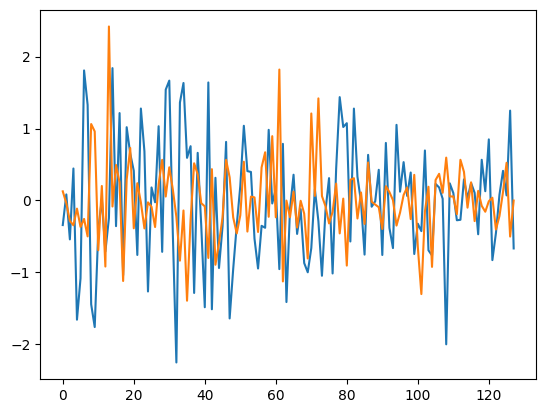

In [90]:
plt.plot(X_train1.iloc[2, :])
plt.plot(X_train2.iloc[2, :])
plt.show()